In [1]:
import networkx as nx
import numpy as np
import pandas as pd

In [5]:
edges = pd.read_csv('7th_graders/edges.csv')
nodes = pd.read_csv('7th_graders/nodes.csv')

print(edges.shape, edges.columns)
print(nodes.shape)

(740, 4) Index(['source', 'target', 'weight', 'layer'], dtype='object')
(29, 3)


In [6]:
edge_list = edges[['source', 'target']].values.tolist()

G = nx.DiGraph()

G.add_edges_from(edge_list)

for _, row in nodes.iterrows():
    G.add_node(row['index'], name=row['name'], pos=row['_pos'])


print('Number of edges: ', G.number_of_edges())
print('Number of nodes: ', G.number_of_nodes())

Number of edges:  376
Number of nodes:  29


In [21]:
def random_strategy(G, num_pivots):
    """
    Select nodes uniformly at random.
    """
    return np.random.choice(list(G.nodes), size=num_pivots, replace=False)

In [7]:
import numpy as np

# Function for random selection based on in-degree
def ran_indeg_strategy(G, num_pivots):
    # Get the in-degree of each node
    indegrees = dict(G.in_degree())
    all_nodes = list(G.nodes)
    
    # Create a list of probabilities proportional to node in-degrees
    degree_sum = sum(indegrees.values())
    probabilities = [indegrees[node] / degree_sum for node in all_nodes]
    
    # Randomly select pivots with probability proportional to their in-degree
    pivots = np.random.choice(all_nodes, size=num_pivots, replace=False, p=probabilities)
    
    return pivots

In [ ]:
# Function for random selection based on out-degree
def ran_outdeg_strategy(G, num_pivots):
    # Get the out-degree of each node
    outdegrees = dict(G.out_degree())
    all_nodes = list(G.nodes)
    
    # Create a list of probabilities proportional to node out-degrees
    degree_sum = sum(outdegrees.values())
    probabilities = [outdegrees[node] / degree_sum for node in all_nodes]
    
    # Randomly select pivots with probability proportional to their out-degree
    pivots = np.random.choice(all_nodes, size=num_pivots, replace=False, p=probabilities)
    
    return pivots

In [9]:
def pagerank_pivot_selection(G, num_pivots):
    """
    Select pivots based on PageRank scores.
    
    Parameters:
    - G: NetworkX directed graph (DiGraph)
    - num_pivots: Number of pivots to select
    
    Returns:
    - List of pivot nodes
    """
    # Calculate PageRank scores
    pagerank_scores = nx.pagerank(G)
    
    # Sort nodes by PageRank scores in descending order
    sorted_nodes = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)
    
    # Select the top nodes as pivots
    pivots = sorted_nodes[:num_pivots]
    return pivots
pivots = pagerank_pivot_selection(G, 3)
pivots

[13, 15, 18]

In [10]:
def estimate_closeness_centrality(G, pivots):
    closeness_estimates = {}
    for node in G.nodes:
        distances = []
        for pivot in pivots:
            shortest_paths = nx.single_source_shortest_path_length(G, source=pivot)
            distance = shortest_paths.get(node, float('inf'))
            distances.append(distance)
        
        finite_distances = [d for d in distances if d != float('inf')]
        if finite_distances:
            avg_distance = sum(finite_distances) / len(finite_distances)
            closeness_estimates[node] = 1 / avg_distance if avg_distance > 0 else 0
        else:
            closeness_estimates[node] = 0
    return closeness_estimates
import numpy as np


In [11]:
def euclidean_distance(exact, estimated):
    """
    Compute the Euclidean distance between two centrality dictionaries.
    
    Parameters:
    - exact: dict, exact centrality values
    - estimated: dict, estimated centrality values
    
    Returns:
    - float, the Euclidean distance
    """
    exact_values = np.array([exact[node] for node in exact])
    estimated_values = np.array([estimated[node] for node in exact])  # Ensure consistent order
    return np.linalg.norm(exact_values - estimated_values)

In [12]:
exact_closeness = nx.closeness_centrality(G)
print('Exact closeness centrality: ', exact_closeness)

Exact closeness centrality:  {0: 0.5957446808510638, 5: 0.5, 7: 0.6363636363636364, 10: 0.7, 11: 0.5833333333333334, 13: 0.7567567567567568, 15: 0.7567567567567568, 16: 0.6511627906976745, 18: 0.7368421052631579, 20: 0.7, 21: 0.7, 25: 0.717948717948718, 26: 0.6829268292682927, 1: 0.6829268292682927, 4: 0.6666666666666666, 2: 0.509090909090909, 3: 0.5714285714285714, 6: 0.5, 9: 0.5490196078431373, 14: 0.7, 19: 0.7, 8: 0.5185185185185185, 22: 0.7, 27: 0.5957446808510638, 28: 0.6511627906976745, 23: 0.6511627906976745, 12: 0.5714285714285714, 17: 0.5490196078431373, 24: 0.56}


In [17]:
def run_experiment(G, pivot_strategy, runs=20):
    exact_closeness = nx.closeness_centrality(G)
    num_nodes = G.number_of_nodes()
    num_pivots_list = [int(num_nodes / 20 * i) for i in range(1, 21)]
    results = []
    
    for run in range(runs):
        for num_pivots in num_pivots_list:
            pivots = pivot_strategy(G, num_pivots)
            estimated_closeness = estimate_closeness_centrality(G, pivots)
            euclidean_dist = euclidean_distance(exact_closeness, estimated_closeness)
            results.append({
                "run": run,
                "num_pivots": num_pivots,
                "strategy": pivot_strategy.__name__,
                "euclidean_distance": euclidean_dist
            })
    return pd.DataFrame(results)     

In [ ]:
strategies = [random_strategy, pagerank_pivot_selection, ran_indeg_strategy, ran_outdeg_strategy]

all_results = pd.DataFrame()
for strategy in strategies:
    strategy_results = run_experiment(G, strategy)
    all_results = pd.concat([all_results, strategy_results], ignore_index=True)


all_results.head()

,run,num_pivots,strategy,euclidean_distance
0,0,1,random_strategy,1.296690
1,0,2,random_strategy,0.795294
2,0,4,random_strategy,0.636475
3,0,5,random_strategy,0.517522
4,0,7,random_strategy,0.311107
...,...,...,...,...
1595,19,23,ran_outdeg_strategy,0.313438
1596,19,24,ran_outdeg_strategy,0.336111
1597,19,26,ran_outdeg_strategy,0.345214
1598,19,27,ran_outdeg_strategy,0.267144


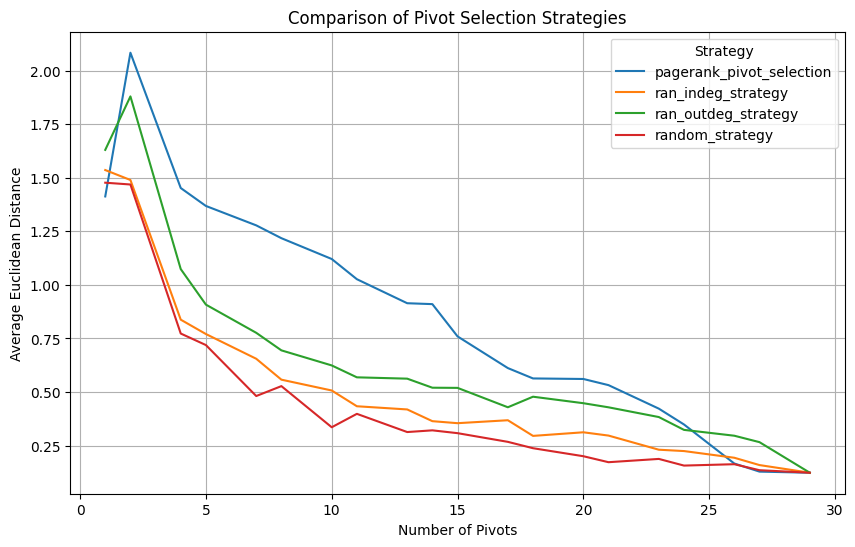

In [23]:
import matplotlib.pyplot as plt

# Group by strategy and number of pivots to calculate the mean Euclidean distance
grouped = all_results.groupby(["strategy", "num_pivots"])["euclidean_distance"].mean().unstack("strategy")

# Plot the results
grouped.plot(figsize=(10, 6))
plt.xlabel("Number of Pivots")
plt.ylabel("Average Euclidean Distance")
plt.title("Comparison of Pivot Selection Strategies")
plt.legend(title="Strategy")
plt.grid(True)
plt.show()

In [ ]:
results_df = run_experiment(G, pagerank_pivot_selection)
results_df

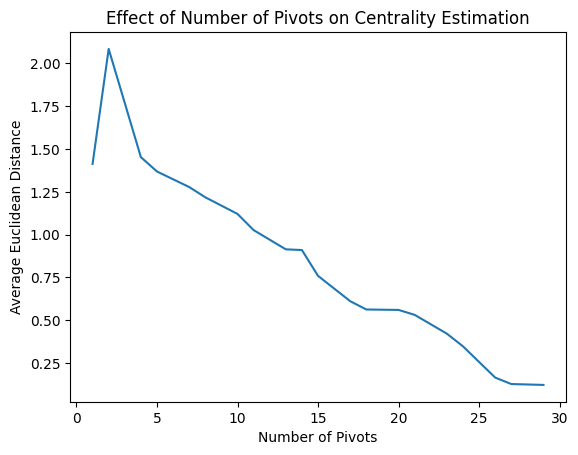

In [15]:
import matplotlib.pyplot as plt

# Plot Euclidean distance vs. number of pivots
avg_results = results_df.groupby("num_pivots")["euclidean_distance"].mean()
plt.plot(avg_results.index, avg_results.values)
plt.xlabel("Number of Pivots")
plt.ylabel("Average Euclidean Distance")
plt.title("Effect of Number of Pivots on Centrality Estimation")
plt.show()